# VGG19 transfer learning
- 가중치 image net
- 데이터셋으로 직접 학습
- 입력 데이터 사이즈 (224,224,3)
- 옵티마이저 adam, 학습률 0.0001
- train 데이터 배치사이즈 100
- 과적합 방지를 위해 earlystopping 적용
- 향상된 모델 저장 적용
- steps_per_epoch = 100
- epochs = 50

In [ ]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from glob import glob
from google.colab import drive
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
import random
import cv2
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import load_model



In [ ]:
valid_path = '/content/drive/MyDrive/안봐도보이조_project/valid_10'
train_path = '/content/drive/MyDrive/안봐도보이조_project/train_10'
test_path = '/content/drive/MyDrive/안봐도보이조_project/test_10'

In [ ]:
# test_path = '/content/drive/MyDrive/안봐도보이조_project/resize_valid_(256,256)'
# train_path = '/content/drive/MyDrive/안봐도보이조_project/resize_train_(256,256)'

In [ ]:
# test_path = '/content/drive/MyDrive/안봐도보이조_project/test_10'
# train_path = '/content/drive/MyDrive/안봐도보이조_project/train_10'

In [ ]:
labels=pd.Series(os.listdir(train_path))

labels=labels.sort_values()
labels=labels.to_list()
labels

['갈아만든배',
 '레쓰비',
 '마운틴듀',
 '밀키스',
 '스프라이트',
 '칠성사이다',
 '코카콜라',
 '트로피카나망고',
 '펩시콜라',
 '환타오렌지']

In [ ]:
numberOfClass = len(glob(train_path + "/*"))
numberOfClass

10

In [ ]:
#num of train images
len(glob(train_path + "/*/*"))

10529

#modeling


In [ ]:
# loading model
tfmodel = VGG19(weights='imagenet', # 이미 학습된 가중치 지정
                 include_top=False, # 분류기 제외
                 input_shape=(224, 224, 3)) 
tfmodel.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정


80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(tfmodel)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 23,237,066
Trainable params: 3,212,682
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer = Adam(0.0001), # 최적화함수 adam사용
              loss = 'categorical_crossentropy', # 손실함수 범주형 교차엔트로피 사용
              metrics = ['accuracy'])

In [ ]:
# 데이터셋 준비
train_datagen = ImageDataGenerator(rescale=1./255,         # 픽셀 값을 0~1 범위로 변환(scaling)
                                   rotation_range=40,      # 40도까지 회전
                                   width_shift_range=0.2,  # 20%까지 좌우 이동
                                   height_shift_range=0.2, # 20%까지 상하 이동
                                   shear_range=0.2,        # 20%까지 기울임
                                   zoom_range=0.2,         # 20%까지 확대/축소
                                   vertical_flip=True)   # 위아래 뒤집기
    
train_data = train_datagen.flow_from_directory(train_path, # 데이터가 존재하는 디렉토리
                                                    batch_size=100, # 배치사이즈(변경가능)
                                                    class_mode='categorical', # 다중 분류이므로 categorical
                                                    target_size=(224,224)) # 모델에 입력해줄 데이터 사이즈(변경가능)

valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_data = valid_datagen.flow_from_directory(valid_path,
                                              batch_size=20,      
                                              class_mode='categorical', 
                                              target_size=(224, 224))

test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_data = test_datagen.flow_from_directory(test_path,
                                                  batch_size=10,      
                                                  class_mode='categorical', 
                                                  target_size=(224, 224),shuffle=False) #test data 에선  shuffle false 로 해야


Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
#모델 최적화 설정
MODEL_DIR = '/content/drive/MyDrive/model_sek/' #model dir 만들기
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = '/content/drive/MyDrive/model_sek/VGG19T_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)
 #valloss 기준으로 좋아지는 모델 저장
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)
 #val loss 기준으로 더이상 안좋아지면 5까지 해보고 그만 두기

In [ ]:
# training model
# batch_size = 50
hist = model.fit(train_data,
                          steps_per_epoch = 100,
                          epochs = 100,
                          validation_data = valid_data,
                          validation_steps =30,
                          callbacks = [early_stopping_callback, checkpointer])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.2733 - accuracy: 0.6454 
Epoch 1: val_loss improved from inf to 0.65794, saving model to /content/drive/MyDrive/model_sek/VGG19T_01-0.6579.hdf5
100/100 [==============================] - 4957s 49s/step - loss: 1.2733 - accuracy: 0.6454 - val_loss: 0.6579 - val_accuracy: 0.8383
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.8713
Epoch 2: val_loss improved from 0.65794 to 0.32917, saving model to /content/drive/MyDrive/model_sek/VGG19T_02-0.3292.hdf5
100/100 [==============================] - 482s 5s/step - loss: 0.5534 - accuracy: 0.8713 - val_loss: 0.3292 - val_accuracy: 0.9467
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.9087
Epoch 3: val_loss improved from 0.32917 to 0.26034, saving model to /content/drive/MyDrive/model_sek/VGG19T_03-0.2603.hdf5
100/100 [==============================] - 193s 2s/step - loss: 0.3912 - accu

In [ ]:
# model = load_model('/content/drive/MyDrive/model_sek/VGG19T_15-0.0434.hdf5')

In [ ]:
print('\n test accuracy: %.4f'% (model.evaluate(test_data))[1])

50/50 [==============================] - 240s 5s/step - loss: 0.0331 - accuracy: 0.9900

 test accuracy: 0.9900


In [ ]:
# writing history
import json, codecs

with open("/content/drive/MyDrive/model_sek/model_VGG19transfer_sek_1.1.json","w") as f:
    json.dump(hist.history,f)

In [ ]:
# # reading history
# with codecs.open("model_VGG19transfer_sek_1.json","r",encoding= "utf-8") as f:
    
#     n = json.loads(f.read())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


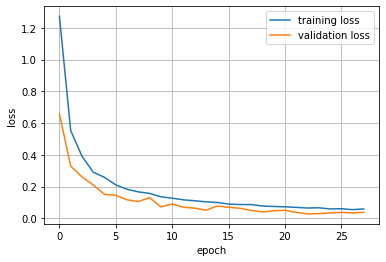

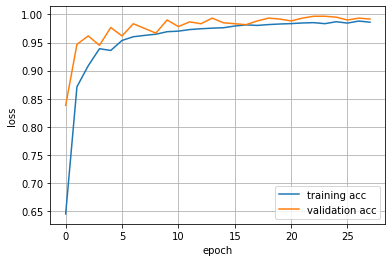

In [ ]:
# visualizing accuracy and loss
print(hist.history.keys())
plt.figure()
plt.plot(hist.history["loss"], label = "training loss")
plt.plot(hist.history["val_loss"], label = "validation loss")
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(hist.history["accuracy"], label = "training acc")
plt.plot(hist.history["val_accuracy"], label = "validation acc")
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


# predict

In [ ]:
# get 25 random images from directory

import random
import cv2

def get25img(directory):
  images = []
  path = glob(directory + "/*/*")
  random_path = random.sample(path, 25)
  for i in random_path:
    image = cv2.imread(i) 
    image = cv2.resize(image,(224,224))         
    images.append(image)
  return images



In [ ]:
path = glob(test_path + "/*/*")
random.sample(path, 25)

['/content/drive/MyDrive/안봐도보이조_project/test_10/트로피카나망고/gen_0_9438.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/펩시콜라/gen_0_9860.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/코카콜라/gen_0_9297.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/스프라이트/gen_0_5776.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/밀키스/gen_0_2331.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/마운틴듀/gen_0_1675.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/코카콜라/10051_38.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/코카콜라/gen_0_8537.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/환타오렌지/gen_0_7022.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/밀키스/gen_0_798.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/레쓰비/gen_0_3728.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_10/펩시콜라/gen_0_4106.jpg',
 '/content/dr

In [ ]:
  #predict  
  pred_images = get25img(test_path)
  pred_images = np.array(pred_images)/255.
  prediction = model.predict(pred_images, verbose = 1)




1/1 [==============================] - 1s 836ms/step


In [ ]:
test_data

In [ ]:
#test data index
dic = test_data.class_indices
dic

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [ ]:
train_data.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [ ]:
dic.keys()

dict_keys(['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'])

In [ ]:
dic.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# label name 을 찾아 오는 함수를 정의한다.
def findKey(search_value):
    for key, value in dic.items():
        if(value == search_value):
            return key
    return -1

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s

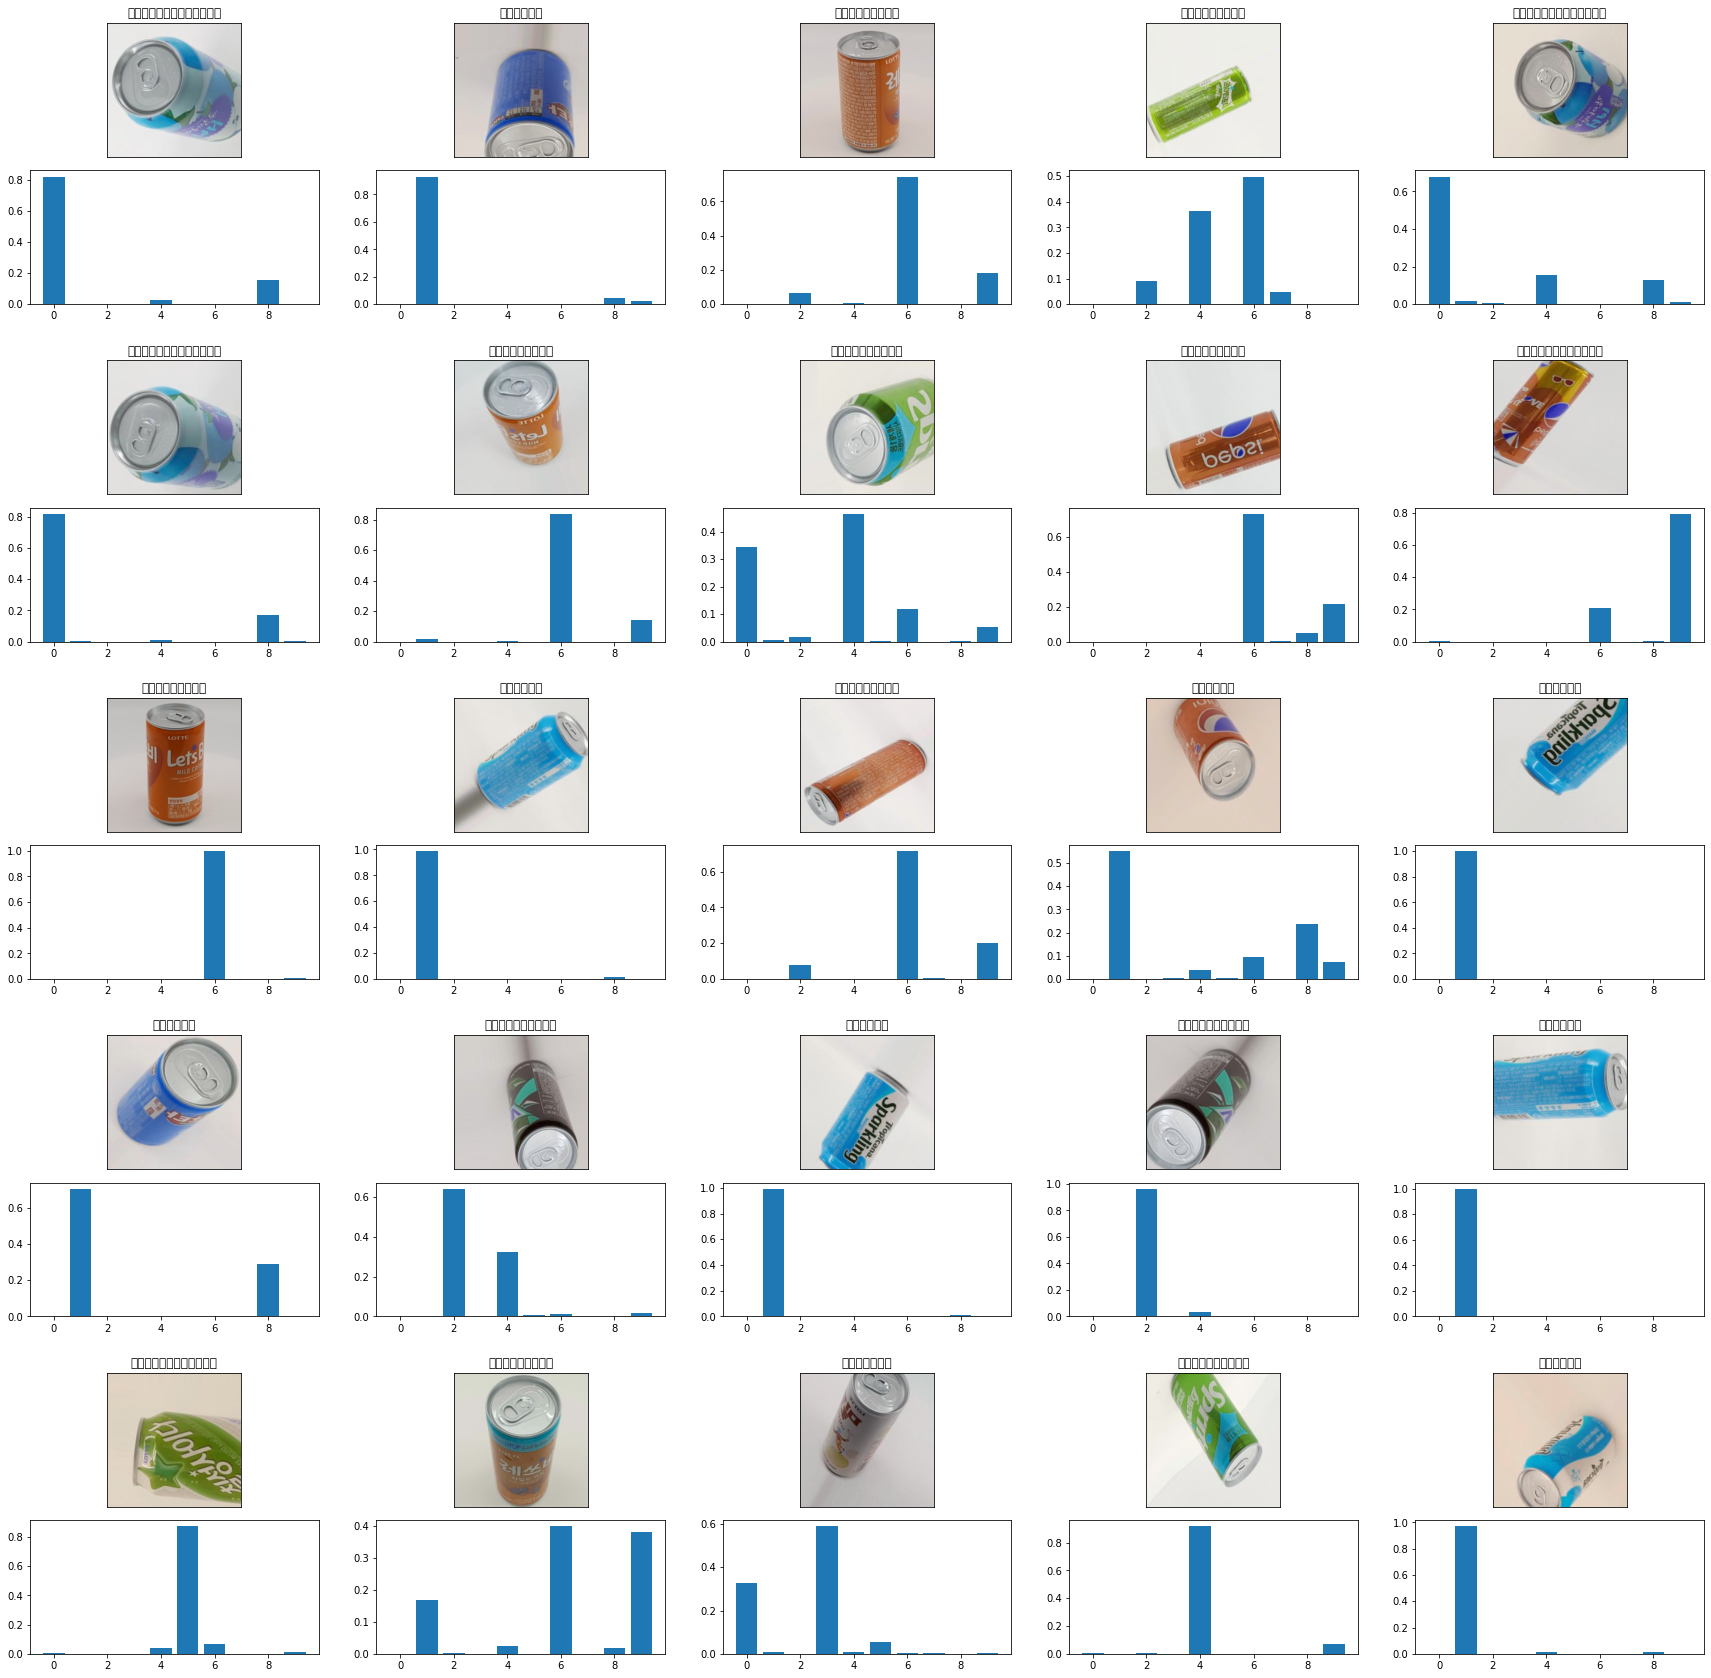

In [ ]:
# 예측한 결과는 아래와 같습니다. 이미지의 위에는 class label을 이미지 아래에는 확률을 나타냅니다.
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    pred_image = np.array([pred_images[i]])
    pred_class = findKey(np.argmax(prediction[i])) 
    pred_prob = prediction[i].reshape(numberOfClass)   # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape 합니다. 
    for j in range(2):
        if (j%2) == 0:                        # 처음에는 이미지와 title(label name) 을 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                 # 그다음은 확률값을 그래프 형태로 보여줍니다. 
            ax = plt.Subplot(fig, inner[j])
            ax.bar(range(numberOfClass),pred_prob)
            fig.add_subplot(ax)

fig.show()


#왜 label 이 안보일까...
#https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/demo_constrained_layout.html#sphx-glr-gallery-subplots-axes-and-figures-demo-constrained-layout-py


In [ ]:


def compare_pred(directory, num):
  path = glob(directory + "/*/*")
  random_path = random.sample(path, num)
  out = []
  for i in random_path:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))  
    image = np.array(image)*1./255
    image = image.reshape(1, 224,224,3)
    prediction =model.predict(image)
    max = np.argmax(prediction)
    akey = i.split('/')[-2]
    pkey = findKey(max) 
    path = i
    out.append([ path, max, akey, pkey])
  out = pd.DataFrame(out, columns = ['path', 'predict', 'a_name', 'p_name'])
  out['compare'] = np.where(out.a_name == out.p_name, 1, 0)
  out = out.sort_values(by = 'compare')
  return out


In [ ]:
df = compare_pred(test_path, 150)
df


,path,predict,a_name,p_name,compare
0,/content/drive/MyDrive/안봐도보이조_project/t...,0,갈아만든배,갈아만든배,1
1,/content/drive/MyDrive/안봐도보이조_project/t...,7,트로피카나망고,트로피카나망고,1
2,/content/drive/MyDrive/안봐도보이조_project/t...,3,밀키스,밀키스,1
3,/content/drive/MyDrive/안봐도보이조_project/t...,5,칠성사이다,칠성사이다,1
4,/content/drive/MyDrive/안봐도보이조_project/t...,2,마운틴듀,마운틴듀,1
...,...,...,...,...,...
145,/content/drive/MyDrive/안봐도보이조_project/t...,7,트로피카나망고,트로피카나망고,1
146,/content/drive/MyDrive/안봐도보이조_project/t...,9,환타오렌지,환타오렌지,1
147,/content/drive/MyDrive/안봐도보이조_project/t...,9,환타오렌지,환타오렌지,1
148,/content/drive/MyDrive/안봐도보이조_project/t...,0,갈아만든배,갈아만든배,1


In [ ]:
df[df['compare']==0]

,path,predict,a_name,p_name,compare
93,/content/drive/MyDrive/안봐도보이조_project/t...,2,갈아만든배,마운틴듀,0
126,/content/drive/MyDrive/안봐도보이조_project/t...,1,펩시콜라,레쓰비,0


In [ ]:
df['compare'].sum()/len(df)

0.9866666666666667

In [ ]:
df_valid = compare_pred(valid_path, 100)

In [ ]:
df_valid

,path,predict,a_name,p_name,compare
0,/content/drive/MyDrive/안봐도보이조_project/v...,0,갈아만든배,갈아만든배,1
1,/content/drive/MyDrive/안봐도보이조_project/v...,3,밀키스,밀키스,1
2,/content/drive/MyDrive/안봐도보이조_project/v...,6,코카콜라,코카콜라,1
3,/content/drive/MyDrive/안봐도보이조_project/v...,0,갈아만든배,갈아만든배,1
4,/content/drive/MyDrive/안봐도보이조_project/v...,1,레쓰비,레쓰비,1
...,...,...,...,...,...
95,/content/drive/MyDrive/안봐도보이조_project/v...,8,펩시콜라,펩시콜라,1
96,/content/drive/MyDrive/안봐도보이조_project/v...,6,코카콜라,코카콜라,1
97,/content/drive/MyDrive/안봐도보이조_project/v...,8,펩시콜라,펩시콜라,1
98,/content/drive/MyDrive/안봐도보이조_project/v...,5,칠성사이다,칠성사이다,1


In [ ]:
df_valid['compare'].sum()/len(df_valid)

1.0

In [ ]:
def compare_pred_real(directory, label_list):
  path = glob(directory + "/*")
  out = []
  for i in path:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))  
    image = np.array(image)*1./255
    image = image.reshape(1, 224,224,3)
    prediction =model.predict(image)
    max = np.argmax(prediction)
    pkey = findKey(max) 
    path = i
    out.append([ path, max,pkey])
  out = pd.DataFrame(out, columns = ['path', 'predict', 'p_name'])
  out['label'] = pd.DataFrame(label_list)
  out['l_name'] = pd.DataFrame(list(map(lambda x: findKey(x), label_list)))
  out['compare'] = np.where(out.label == out.predict, 1, 0)
  out.sort_values(by = ['compare'], inplace = True)
  return out


In [ ]:
realpath = '/content/drive/MyDrive/안봐도보이조_project/test_real'
glob(realpath + "/*")

['/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_02_23_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_02_56_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_03_27_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_03_41_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_04_30_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_04_44_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_04_54_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_03_38_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_03_06_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_04_05_Pro.jpg',
 '/content/drive/MyDrive/안봐도보이조_project/test_real/WIN_20220323_15_04_07_Pro.jpg',
 '/content/drive/MyDr

In [ ]:
label_list = [1,1,8,4,3,3,9,4,8,6,6,9]
'''
]

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}'''

"\n]\n\n{'갈아만든배': 0,\n '레쓰비': 1,\n '마운틴듀': 2,\n '밀키스': 3,\n '스프라이트': 4,\n '칠성사이다': 5,\n '코카콜라': 6,\n '트로피카나망고': 7,\n '펩시콜라': 8,\n '환타오렌지': 9}"

In [ ]:
df_real = compare_pred_real(realpath, label_list)

In [ ]:
df_real

,path,predict,p_name,label,l_name,compare
2,/content/drive/MyDrive/안봐도보이조_project/t...,1,레쓰비,8,펩시콜라,0
3,/content/drive/MyDrive/안봐도보이조_project/t...,5,칠성사이다,4,스프라이트,0
4,/content/drive/MyDrive/안봐도보이조_project/t...,0,갈아만든배,3,밀키스,0
7,/content/drive/MyDrive/안봐도보이조_project/t...,5,칠성사이다,4,스프라이트,0
9,/content/drive/MyDrive/안봐도보이조_project/t...,0,갈아만든배,6,코카콜라,0
0,/content/drive/MyDrive/안봐도보이조_project/t...,1,레쓰비,1,레쓰비,1
1,/content/drive/MyDrive/안봐도보이조_project/t...,1,레쓰비,1,레쓰비,1
5,/content/drive/MyDrive/안봐도보이조_project/t...,3,밀키스,3,밀키스,1
6,/content/drive/MyDrive/안봐도보이조_project/t...,9,환타오렌지,9,환타오렌지,1
8,/content/drive/MyDrive/안봐도보이조_project/t...,8,펩시콜라,8,펩시콜라,1


In [ ]:
list111 = [9,9,9,9,8,8,8,8,1,1,1,1,3,3,3,5,5,5,6,6,6]

In [ ]:
df_real111 = compare_pred_real('/content/drive/MyDrive/안봐도보이조_project/111', list111)


In [ ]:
df_real111

,path,predict,p_name,label,l_name,compare
20,/content/drive/MyDrive/안봐도보이조_project/1...,9,환타오렌지,6,코카콜라,0
14,/content/drive/MyDrive/안봐도보이조_project/1...,9,환타오렌지,3,밀키스,0
13,/content/drive/MyDrive/안봐도보이조_project/1...,9,환타오렌지,3,밀키스,0
12,/content/drive/MyDrive/안봐도보이조_project/1...,9,환타오렌지,3,밀키스,0
18,/content/drive/MyDrive/안봐도보이조_project/1...,6,코카콜라,6,코카콜라,1
17,/content/drive/MyDrive/안봐도보이조_project/1...,5,칠성사이다,5,칠성사이다,1
16,/content/drive/MyDrive/안봐도보이조_project/1...,5,칠성사이다,5,칠성사이다,1
15,/content/drive/MyDrive/안봐도보이조_project/1...,5,칠성사이다,5,칠성사이다,1
11,/content/drive/MyDrive/안봐도보이조_project/1...,1,레쓰비,1,레쓰비,1
19,/content/drive/MyDrive/안봐도보이조_project/1...,6,코카콜라,6,코카콜라,1
